# <span style='color:Black'> **Verifiable Support Vector Machine**  </span> 

The Support Vector Machines (SVM) model is a supervised learning technique used for classification and regression. It is employed to solve binary classification problems where it identifies the hyperplane that best divides a data set into classes. This hyperplane results from maximizing the margin between the two classes. By determining this optimal hyperplane, predictions can be made for new data points and understand how the input attributes influence classification.

Below, we provide a brief review of implementing an SVM model using the Gradient Descent method for the linear kernel in Python, which we will later convert to Cairo to transform it into a verifiable ZKML (support vector machine model), using Orion's library. This allows an opportunity to familiarize oneself with the main functions and operators that the framework offers for the implementation of the SVM.

### <span style='color:Black'> **DataSet Generate**  </span>

For the purposes of this tutorial, we generated linearly separable data using make_blobs from Scikit-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1

X = np.hstack((X, np.ones((X.shape[0], 1))))

X_train, y_train = X[:100, :], y[:100]
X_test, y_test = X[100:, :], y[100:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 3) (100,) (50, 3) (50,)


Now we will visualize the training data using a scatter plot, where the points are colored based on their class labels, which in our case will be 1 and -1

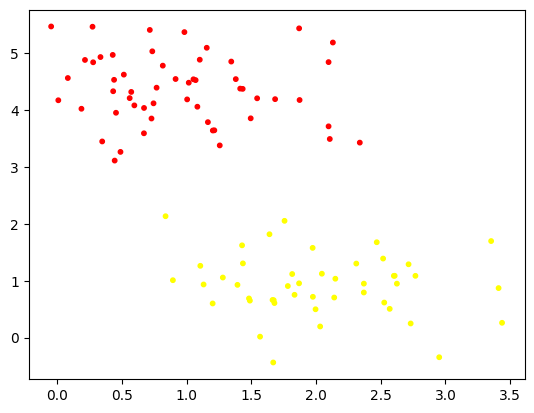

In [2]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap='autumn')

### <span style='color:Black'> **Loss function, gradient and Weight init**  </span>

We will start by generating the key functions for SVM.

Next, we'll define the loss functions and its gradient, with $\mathbf{L2}$ regularization, both necessary to train our SVM.

In the case of the loss function in SVM, the Hinge Loss ($\max(0, 1 - y_i \times (\mathbf{w} \cdot \mathbf{x}_i))$) is used, which measures how far a sample is on the "wrong side" of the margin. If the sample is on the correct side of the margin, the loss is 0.

$\text{Loss Function}$  = $ \frac{1}{N} \sum_{i=1}^{N} \max(0, 1 - y_i \times (\mathbf{w} \cdot \mathbf{x}_i)) + C \times \frac{1}{2} \times \mathbf{w} \cdot \mathbf{w}$

$\text{Gradient}$  =  $\frac{1}{N} \sum_{i=1}^{N} \left( -y_i \times \mathbf{x}_i \text{ (si } y_i \times (\mathbf{w} \cdot \mathbf{x}_i) < 1 \text{) } \right) + C \times \mathbf{w}$

For the purposes of this tutorial, we initialize $\mathbf{w}$ as an array of $\mathbf{0's}$

In [3]:
def loss_function(w, X, y, C):  
    hinge_loss = np.maximum(0, 1 - y * np.dot(X, w)) 
    regularization_term = 0.5 * np.dot(w, w)  # Regularización L2 ###
    total_loss = np.mean(hinge_loss) + C * regularization_term ###
    return total_loss

def loss_gradient(w, X, y, C):     
    mask = (y * (np.dot(X, w))) < 1    #<1
    gradient = (-np.dot(mask * y, X) / len(y)) +  C*w
    return gradient

# Gradiente descendente
losses = []
w = np.zeros(3)

### <span style='color:Black'> **Initial hyperparameters**  </span>

Now, we declare the hyperparameters: learning rate (learning_rate), the number of epochs (num_epochs), and the regularization parameter (C). Then, we will use gradient descent to adjust the weights of the SVM model. For the purposes of this tutorial, we stick with the following hyperparameters; however, the hyperplane acquisition could be improved with their adjustment.

In [4]:
learning_rate = 0.01
num_epochs = 100
C = 1

### <span style='color:Black'> **Training**  </span>

In [5]:
for epoch in range(num_epochs):
    loss = loss_function(w,X_train, y_train, C)
    losses.append(loss)

    if epoch % 25 == 0 or epoch  == 99:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

    gradient_w = loss_gradient(w, X_train, y_train,C)
    w -= learning_rate * gradient_w

Epoch 0, Loss: 1.0000
Epoch 25, Loss: 0.5300
Epoch 50, Loss: 0.4594
Epoch 75, Loss: 0.4238
Epoch 99, Loss: 0.4092


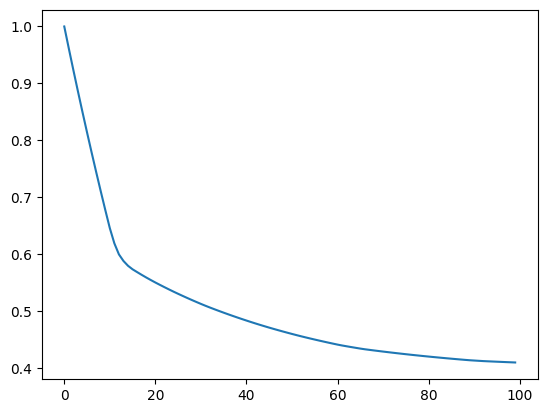

In [6]:
plt.plot(losses)

After training the model and observing the decrease of the loss function, we evaluate its performance on both the training and test data. We will calculate the accuracy and display the final loss on the training data. In our case, the weights $\mathbf{w}$ and the accuracies will be the values against which we compare the SVM implementation in Cairo with Orion.

### <span style='color:Black'> **Evaluate model on training data**  </span>

In [7]:
def predict(X, w):
    return np.sign(np.dot(X, w))

predictions = predict(X_train, w)
final_loss = loss_function(w, X_train, y_train,C)

print("Accuracy: {}".format((predictions == y_train).mean()))
print("Final loss: {}".format(final_loss))

Accuracy: 0.99
Final loss: 0.408927300213472


### <span style='color:Black'> **Evaluate model on test data**  </span>

In [8]:
predictions = predict(X_test, w)

print("Accuracy: {}".format((predictions == y_test).mean()))

Accuracy: 0.98


In [9]:
w

array([ 0.36715632, -0.35873007,  0.12536368])

Next, we will visualize the obtained hyperplane, determined by $\mathbf{w} = (0.367, -0.358, 0.125)$ and the way it separates the classes in the test data.

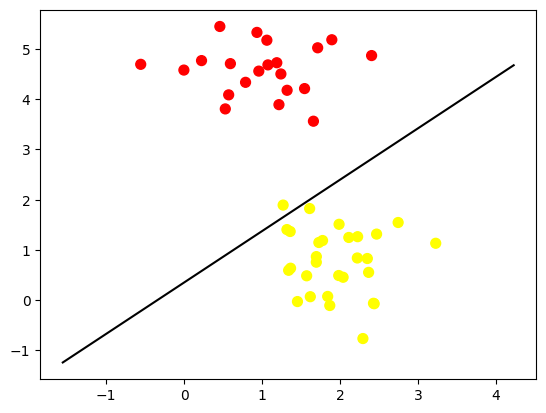

In [10]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='autumn')

x_plot = np.linspace(X_test[:, 0].min() - 1, X_test[:, 0].max() + 1, 100)
y_plot = (-w[0] / w[1]) * x_plot - (w[2]/w[1]) #
plt.plot(x_plot, y_plot, 'k-')

The equation of the line obtained is $\mathbf{Y} = 1.023\mathbf{X} + 0.349$

## <span style='color:Black'> **Convert your model to Cairo**  </span>

### <span style='color:Black'> **Generating Cairo files**  </span>

Now let's generate Cairo files for each tensor in the object.

In [11]:
def decimal_to_fp16x16(num):

    whole_num = int(num)
    fractional_part = int((num - whole_num) * 65536)
    fp_number = (whole_num << 16) + fractional_part
    return fp_number

In [12]:
import os

In [13]:
os.makedirs("src/generated", exist_ok=True)

In [14]:
tensor_name = ["X_train", "Y_train", "X_test", "Y_test"]

def generate_cairo_files(data, name):

    with open(os.path.join('src', 'generated', f"{name}.cairo"), "w") as f:
        f.write(
            "use array::ArrayTrait;\n" +
            "use orion::operators::tensor::{core::{Tensor, TensorTrait, ExtraParams}, implementations::impl_tensor_fp::Tensor_fp};\n" +
            "use orion::numbers::fixed_point::{core::{FixedTrait, FixedType, FixedImpl}, implementations::fp16x16::core::FP16x16Impl};\n" +
            "\n" + f"fn {name}() -> Tensor<FixedType>" + "{\n\n" + 
            "let mut shape = ArrayTrait::new();\n"
        )
        for dim in data.shape:
            f.write(f"shape.append({dim});\n")
    
        f.write("let mut data = ArrayTrait::new();")
        for val in np.nditer(data.flatten()):
            f.write(f"data.append(FixedTrait::new({abs(int(decimal_to_fp16x16(val)))}, {str(val < 0).lower()}));\n")
        f.write(
            "let extra = ExtraParams { fixed_point: Option::Some(FixedImpl::FP16x16(())) };\n" + 
            "let tensor = TensorTrait::<FixedType>::new(shape.span(), data.span(), Option::Some(extra));\n" +
            "return tensor;\n}"
        )

with open(f"src/generated.cairo", "w") as f:
    for n in tensor_name:
        f.write(f"mod {n};\n")

generate_cairo_files(X_train, "X_train")
generate_cairo_files(X_test, "X_test")
generate_cairo_files(y_train, "Y_train")
generate_cairo_files(y_test, "Y_test")

<span style='color:Black'> **Convert hyperparameters to FP16x16**  </span>


In [15]:
print(decimal_to_fp16x16(learning_rate))
print(decimal_to_fp16x16(C))
print(decimal_to_fp16x16(num_epochs))

655
65536
6553600


<span style='color:Black'> **Get an estimate for the initial and final loss value, and final weights in FP16x16**  </span>

In [16]:
w = np.array([decimal_to_fp16x16(w[0]),
decimal_to_fp16x16(w[1]),
decimal_to_fp16x16(w[2])])

print("Initial loss: {}".format(decimal_to_fp16x16(losses[0])))
print("Final loss: {}".format(decimal_to_fp16x16(final_loss)))
print("Weights: {}".format(w))

Initial loss: 65536
Final loss: 26799
Weights: [ 24061 -23509   8215]


For the implementation of SVM in Cairo with Orion, please visit the Convert your model section within the [Verifiable Support Vector Machine tutorial][def]

[def]: ../tutorial/VerifiableSupportVectorMachineTutorial.md